In [3]:
"""
baseline_mobilenetv2_cifar10.py

1. Load CIFAR-10 (train/test).
2. Build a pre-trained MobileNetV2 and adapt it to 10 classes.
3. Train/fine-tune on CIFAR-10.
4. Measure baseline accuracy, model size, parameter count, and CPU latency.
5. Save the baseline checkpoint for later pruning experiments.
"""

import time
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights


# -----------------------------
# 1. Basic config
# -----------------------------

DEVICE = torch.device("cpu")  # keep CPU only to mimic an edge device
BATCH_SIZE = 256
NUM_EPOCHS = 15             # adjust depending on time/accuracy
LEARNING_RATE = 0.001
CHECKPOINT_PATH = "mobilenetv2_cifar10_baseline.pth"
os.makedirs("checkpoints", exist_ok=True)
CHECKPOINT_PATH = os.path.join("checkpoints", CHECKPOINT_PATH)

torch.manual_seed(42)


# -----------------------------
# 2. CIFAR-10 dataloaders
# -----------------------------
# CIFAR-10: 32x32 RGB images, 10 classes.

# We resize to 96x96 or 128x128 because MobileNetV2 expects larger inputs.
IMG_SIZE = 64

# Normalization values often used for CIFAR-10 (approximate)
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2470, 0.2435, 0.2616)

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),         # simple augmentation
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=train_transform,
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=test_transform,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)


# -----------------------------
# 3. Build MobileNetV2 for CIFAR-10
# -----------------------------
# We take an ImageNet-pretrained MobileNetV2 and replace the last layer
# so it outputs 10 classes instead of 1000.

def build_model():
    # Load pre-trained weights
    weights = MobileNet_V2_Weights.IMAGENET1K_V1
    model = mobilenet_v2(weights=weights)

    # Number of features going into the final classifier layer
    in_features = model.classifier[-1].in_features

    # Replace final layer with a new Linear layer for 10 CIFAR-10 classes
    model.classifier[-1] = nn.Linear(in_features, 10)

    model = model.to(DEVICE)
    return model


model = build_model()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


# -----------------------------
# 4. Training and evaluation loops
# -----------------------------

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)           # forward pass
        loss = criterion(outputs, labels) # compute loss
        loss.backward()                   # backprop
        optimizer.step()                  # update weights

        running_loss += loss.item() * images.size(0)

        # compute number of correct predictions
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion=None):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)
            if criterion is not None:
                loss = criterion(outputs, labels)
                running_loss += loss.item() * images.size(0)

            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    if criterion is not None:
        loss = running_loss / total
        return loss, acc
    else:
        return acc


# -----------------------------
# 5. Train baseline model
# -----------------------------

best_test_acc = 0.0

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    test_loss, test_acc = evaluate(model, test_loader, criterion)

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), CHECKPOINT_PATH)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]"
          f"  Train Loss: {train_loss:.4f}  Train Acc: {train_acc*100:.2f}%"
          f"  Test Loss: {test_loss:.4f}  Test Acc: {test_acc*100:.2f}%")

print(f"\nBest test accuracy: {best_test_acc*100:.2f}%")
print(f"Best model saved to: {CHECKPOINT_PATH}")


# -----------------------------
# 6. Reload best baseline model
# -----------------------------
# We reload to be sure subsequent pruning will always start from the best checkpoint.

baseline_model = build_model()
baseline_model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=DEVICE))
baseline_model.eval()


# -----------------------------
# 7. Baseline metrics: params, size, accuracy, latency
# -----------------------------

# (a) Parameter count
total_params = sum(p.numel() for p in baseline_model.parameters())
print(f"Total parameters (baseline): {total_params / 1e6:.2f}M")

# (b) Model file size on disk (in MB)
file_size_bytes = os.path.getsize(CHECKPOINT_PATH)
file_size_mb = file_size_bytes / (1024 * 1024)
print(f"Checkpoint size (baseline): {file_size_mb:.2f} MB")

# (c) Test accuracy (already known, but compute once more for clarity)
test_loss, test_acc = evaluate(baseline_model, test_loader, criterion)
print(f"Baseline test accuracy: {test_acc * 100:.2f}%")

# (d) Inference latency on CPU
def measure_latency(model, loader, num_batches=50):
    """
    Measure average inference time per image on CPU over `num_batches`.
    """
    model.eval()
    n_images = 0
    total_time = 0.0

    with torch.no_grad():
        # Warm-up: a few batches to avoid cold-start effects
        warmup_batches = 5
        warmup_iter = iter(loader)
        for _ in range(warmup_batches):
            try:
                images, _ = next(warmup_iter)
            except StopIteration:
                break
            images = images.to(DEVICE)
            _ = model(images)

        # Actual timing
        batch_iter = iter(loader)
        for _ in range(num_batches):
            try:
                images, _ = next(batch_iter)
            except StopIteration:
                break

            images = images.to(DEVICE)
            start = time.time()
            _ = model(images)          # forward pass only
            end = time.time()

            batch_time = end - start
            total_time += batch_time
            n_images += images.size(0)

    avg_time_per_image = total_time / n_images if n_images > 0 else 0.0
    return avg_time_per_image


avg_latency = measure_latency(baseline_model, test_loader, num_batches=50)
print(f"Baseline average latency: {avg_latency*1000:.3f} ms per image (CPU)")


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/15]  Train Loss: 0.5650  Train Acc: 80.53%  Test Loss: 0.4230  Test Acc: 85.43%
Epoch [2/15]  Train Loss: 0.3399  Train Acc: 88.44%  Test Loss: 0.3942  Test Acc: 86.82%
Epoch [3/15]  Train Loss: 0.2751  Train Acc: 90.58%  Test Loss: 0.3960  Test Acc: 87.19%
Epoch [4/15]  Train Loss: 0.2302  Train Acc: 92.05%  Test Loss: 0.3511  Test Acc: 88.31%
Epoch [5/15]  Train Loss: 0.2067  Train Acc: 92.85%  Test Loss: 0.3703  Test Acc: 88.10%
Epoch [6/15]  Train Loss: 0.1801  Train Acc: 93.74%  Test Loss: 0.3697  Test Acc: 89.20%
Epoch [7/15]  Train Loss: 0.1611  Train Acc: 94.44%  Test Loss: 0.3451  Test Acc: 89.15%
Epoch [8/15]  Train Loss: 0.1470  Train Acc: 94.98%  Test Loss: 0.3751  Test Acc: 88.84%
Epoch [9/15]  Train Loss: 0.1363  Train Acc: 95.33%  Test Loss: 0.4235  Test Acc: 88.02%
Epoch [10/15]  Train Loss: 0.1329  Train Acc: 95.35%  Test Loss: 0.3552  Test Acc: 89.80%
Epoch [11/15]  Train Loss: 0.1206

In [6]:
import torch.nn.utils.prune as prune
import copy
import pandas as pd

results = []  # will store dicts with metrics for each experiment

def count_nonzero_params(model):
    total = 0
    nonzero = 0
    for p in model.parameters():
        if p is None:
            continue
        numel = p.numel()
        nz = torch.count_nonzero(p).item()
        total += numel
        nonzero += nz
    sparsity = 1.0 - nonzero / total
    return total, nonzero, sparsity

def evaluate_with_latency(model, loader, criterion, num_batches_latency=30):
    # accuracy
    test_loss, test_acc = evaluate(model, loader, criterion)

    # latency
    avg_latency = measure_latency(model, loader, num_batches=num_batches_latency)

    # params / sparsity
    total_params, nonzero_params, sparsity = count_nonzero_params(model)

    return {
        "test_loss": test_loss,
        "test_acc": test_acc,
        "latency_ms_per_image": avg_latency * 1000,
        "total_params": total_params,
        "nonzero_params": nonzero_params,
        "sparsity": sparsity,
    }


/Users/shehariyarfs/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/shehariyarfs/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [7]:
def apply_unstructured_global_l1_pruning(model, amount):
    """
    Global unstructured magnitude pruning across Conv2d and Linear layers.
    `amount` is the fraction of weights to prune (e.g., 0.3 for 30%).
    """
    parameters_to_prune = []
    for module_name, module in model.named_modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            parameters_to_prune.append((module, "weight"))

    # Global pruning: chooses smallest |w| across all selected layers
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=amount,
    )

    return model


In [8]:
def apply_structured_channel_pruning(model, amount_per_layer):
    """
    Structured pruning: remove a fraction of channels (filters) per Conv2d layer
    based on L2 norm along the output channel dimension.
    `amount_per_layer` is the fraction of channels pruned in each Conv2d.
    """
    for module_name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            # dim=0 -> prune output channels (filters)
            prune.ln_structured(
                module,
                name="weight",
                amount=amount_per_layer,
                n=2,      # L2 norm
                dim=0,
            )
    return model


In [9]:
def finetune(model, train_loader, test_loader, criterion, lr=1e-4, epochs=5):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        test_loss, test_acc = evaluate(model, test_loader, criterion)
        print(f"[Finetune] Epoch {epoch+1}/{epochs}  "
              f"Train Acc: {train_acc*100:.2f}%  Test Acc: {test_acc*100:.2f}%")
    return model

sparsity_levels = [0.3, 0.5, 0.7]  # 30%, 50%, 70%

# ONE-SHOT + UNSTRUCTURED
for s in sparsity_levels:
    print(f"\n=== One-shot UNSTRUCTURED pruning to {int(s*100)}% global sparsity ===")
    model_oneshot_unstr = copy.deepcopy(baseline_model)

    # apply pruning
    apply_unstructured_global_l1_pruning(model_oneshot_unstr, amount=s)

    # finetune
    model_oneshot_unstr = finetune(model_oneshot_unstr, train_loader, test_loader, criterion,
                                   lr=1e-4, epochs=5)

    # remove pruning re-parametrization (optional but clean)
    for module in model_oneshot_unstr.modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            if hasattr(module, "weight_orig"):
                prune.remove(module, "weight")

    # evaluate + latency
    metrics = evaluate_with_latency(model_oneshot_unstr, test_loader, criterion)
    metrics.update({
        "method": "unstructured",
        "regime": "one-shot",
        "target_sparsity": s,
    })
    results.append(metrics)
    print(metrics)



=== One-shot UNSTRUCTURED pruning to 30% global sparsity ===
[Finetune] Epoch 1/5  Train Acc: 97.88%  Test Acc: 91.54%
[Finetune] Epoch 2/5  Train Acc: 98.84%  Test Acc: 91.55%
[Finetune] Epoch 3/5  Train Acc: 99.27%  Test Acc: 91.63%
[Finetune] Epoch 4/5  Train Acc: 99.50%  Test Acc: 91.67%
[Finetune] Epoch 5/5  Train Acc: 99.58%  Test Acc: 91.74%
{'test_loss': 0.3665273476600647, 'test_acc': 0.9174, 'latency_ms_per_image': 1.0042688809335232, 'total_params': 2236682, 'nonzero_params': 1575914, 'sparsity': 0.2954233100637462, 'method': 'unstructured', 'regime': 'one-shot', 'target_sparsity': 0.3}

=== One-shot UNSTRUCTURED pruning to 50% global sparsity ===
[Finetune] Epoch 1/5  Train Acc: 97.33%  Test Acc: 91.45%
[Finetune] Epoch 2/5  Train Acc: 98.61%  Test Acc: 91.60%
[Finetune] Epoch 3/5  Train Acc: 99.11%  Test Acc: 91.58%
[Finetune] Epoch 4/5  Train Acc: 99.42%  Test Acc: 91.71%
[Finetune] Epoch 5/5  Train Acc: 99.49%  Test Acc: 91.74%
{'test_loss': 0.35556316118240355, 'test_a

In [10]:
# ONE-SHOT + STRUCTURED
for s in sparsity_levels:
    print(f"\n=== One-shot STRUCTURED pruning (per-layer {int(s*100)}% channels) ===")
    model_oneshot_struct = copy.deepcopy(baseline_model)

    apply_structured_channel_pruning(model_oneshot_struct, amount_per_layer=s)

    model_oneshot_struct = finetune(model_oneshot_struct, train_loader, test_loader, criterion,
                                    lr=1e-4, epochs=5)

    for module in model_oneshot_struct.modules():
        if isinstance(module, nn.Conv2d):
            if hasattr(module, "weight_orig"):
                prune.remove(module, "weight")

    metrics = evaluate_with_latency(model_oneshot_struct, test_loader, criterion)
    metrics.update({
        "method": "structured",
        "regime": "one-shot",
        "target_sparsity": s,
    })
    results.append(metrics)
    print(metrics)



=== One-shot STRUCTURED pruning (per-layer 30% channels) ===
[Finetune] Epoch 1/5  Train Acc: 67.84%  Test Acc: 73.85%
[Finetune] Epoch 2/5  Train Acc: 78.53%  Test Acc: 78.79%
[Finetune] Epoch 3/5  Train Acc: 82.80%  Test Acc: 81.17%
[Finetune] Epoch 4/5  Train Acc: 85.22%  Test Acc: 82.67%
[Finetune] Epoch 5/5  Train Acc: 87.30%  Test Acc: 83.72%
{'test_loss': 0.4779845253944397, 'test_acc': 0.8372, 'latency_ms_per_image': 1.0446346675356228, 'total_params': 2236682, 'nonzero_params': 1579486, 'sparsity': 0.2938263016378725, 'method': 'structured', 'regime': 'one-shot', 'target_sparsity': 0.3}

=== One-shot STRUCTURED pruning (per-layer 50% channels) ===
[Finetune] Epoch 1/5  Train Acc: 39.39%  Test Acc: 50.28%
[Finetune] Epoch 2/5  Train Acc: 54.61%  Test Acc: 57.81%
[Finetune] Epoch 3/5  Train Acc: 61.15%  Test Acc: 61.76%
[Finetune] Epoch 4/5  Train Acc: 65.17%  Test Acc: 65.86%
[Finetune] Epoch 5/5  Train Acc: 68.09%  Test Acc: 66.79%
{'test_loss': 0.9479700531005859, 'test_acc'

In [11]:
def iterative_unstructured_pruning(
    baseline_model,
    final_sparsity,
    step_sparsity=0.1,
    finetune_epochs_per_step=2,
    lr=1e-4,
):
    """
    Iterative global unstructured pruning:
    - At each step, increase global sparsity by `step_sparsity`
      and finetune for a few epochs.
    - Stop when the total sparsity reaches `final_sparsity`.
    """
    model = copy.deepcopy(baseline_model)

    current_target = 0.0
    while current_target < final_sparsity - 1e-6:
        current_target = min(current_target + step_sparsity, final_sparsity)
        print(f"\n[Iterative] Pruning to {int(current_target*100)}% global sparsity")

        # Important: we reapply global pruning based on current weights and target
        apply_unstructured_global_l1_pruning(model, amount=current_target)

        # Finetune a bit
        model = finetune(model, train_loader, test_loader, criterion,
                         lr=lr, epochs=finetune_epochs_per_step)

    # Remove reparam
    for module in model.modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            if hasattr(module, "weight_orig"):
                prune.remove(module, "weight")

    return model

# ITERATIVE UNSTRUCTURED at the same final sparsity levels
for s in sparsity_levels:
    print(f"\n=== Iterative UNSTRUCTURED pruning to {int(s*100)}% ===")
    model_iter_unstr = iterative_unstructured_pruning(
        baseline_model,
        final_sparsity=s,
        step_sparsity=0.1,
        finetune_epochs_per_step=2,
        lr=1e-4,
    )

    metrics = evaluate_with_latency(model_iter_unstr, test_loader, criterion)
    metrics.update({
        "method": "unstructured",
        "regime": "iterative",
        "target_sparsity": s,
    })
    results.append(metrics)
    print(metrics)



=== Iterative UNSTRUCTURED pruning to 30% ===

[Iterative] Pruning to 10% global sparsity
[Finetune] Epoch 1/2  Train Acc: 98.03%  Test Acc: 91.46%
[Finetune] Epoch 2/2  Train Acc: 98.95%  Test Acc: 91.65%

[Iterative] Pruning to 20% global sparsity
[Finetune] Epoch 1/2  Train Acc: 99.31%  Test Acc: 91.54%
[Finetune] Epoch 2/2  Train Acc: 99.51%  Test Acc: 91.85%

[Iterative] Pruning to 30% global sparsity
[Finetune] Epoch 1/2  Train Acc: 99.39%  Test Acc: 91.61%
[Finetune] Epoch 2/2  Train Acc: 99.56%  Test Acc: 91.62%
{'test_loss': 0.3421637279510498, 'test_acc': 0.9162, 'latency_ms_per_image': 1.3500005938112736, 'total_params': 2236682, 'nonzero_params': 1144212, 'sparsity': 0.4884333132738583, 'method': 'unstructured', 'regime': 'iterative', 'target_sparsity': 0.3}

=== Iterative UNSTRUCTURED pruning to 50% ===

[Iterative] Pruning to 10% global sparsity
[Finetune] Epoch 1/2  Train Acc: 97.94%  Test Acc: 91.64%
[Finetune] Epoch 2/2  Train Acc: 98.91%  Test Acc: 91.53%

[Iterative

In [12]:
df_results = pd.DataFrame(results)
df_results["test_acc_percent"] = df_results["test_acc"] * 100
df_results["sparsity_percent"] = df_results["sparsity"] * 100

display(df_results)


,test_loss,test_acc,latency_ms_per_image,total_params,nonzero_params,sparsity,method,regime,target_sparsity,test_acc_percent,sparsity_percent
0,0.366527,0.9174,1.004269,2236682,1575914,0.295423,unstructured,one-shot,0.3,91.74,29.542331
1,0.355563,0.9174,0.948668,2236682,1135402,0.492372,unstructured,one-shot,0.5,91.74,49.237218
2,0.305656,0.9142,1.222086,2236682,694890,0.689321,unstructured,one-shot,0.7,91.42,68.932106
3,0.477985,0.8372,1.044635,2236682,1579486,0.293826,structured,one-shot,0.3,83.72,29.382630
4,0.947970,0.6679,1.256873,2236682,1141802,0.489511,structured,one-shot,0.5,66.79,48.951080
5,1.264464,0.5479,0.970620,2236682,704118,0.685195,structured,one-shot,0.7,54.79,68.519530
6,0.342164,0.9162,1.350001,2236682,1144212,0.488433,unstructured,iterative,0.3,91.62,48.843331
7,0.347496,0.8872,1.336157,2236682,367149,0.835851,unstructured,iterative,0.5,88.72,83.585105
8,2.294167,0.1236,1.274738,2236682,74085,0.966877,unstructured,iterative,0.7,12.36,96.687728


In [13]:
def iterative_structured_pruning(
    baseline_model,
    final_sparsity,
    step_sparsity=0.1,
    finetune_epochs_per_step=2,
    lr=1e-4,
):
    """
    Iterative structured channel pruning:
    - At each step, prune `step_sparsity` fraction of channels per Conv2d layer
      (on top of what is already pruned) using L2-norm-based ln_structured.
    - After each step, finetune for a few epochs.
    - Stop when per-layer sparsity is around `final_sparsity`.
    NOTE: Because ln_structured is called repeatedly, actual sparsity may differ
    a bit from the nominal target.
    """
    model = copy.deepcopy(baseline_model)

    current_target = 0.0
    while current_target < final_sparsity - 1e-6:
        current_target = min(current_target + step_sparsity, final_sparsity)
        print(f"\n[Iterative] STRUCTURED pruning: adding {int(step_sparsity*100)}% "
              f"channels pruned per layer (target ≈ {int(current_target*100)}%)")

        # Apply additional per-layer structured pruning
        apply_structured_channel_pruning(model, amount_per_layer=step_sparsity)

        # Finetune a bit after this pruning step
        model = finetune(
            model,
            train_loader,
            test_loader,
            criterion,
            lr=lr,
            epochs=finetune_epochs_per_step,
        )

    # Remove pruning reparametrization
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            if hasattr(module, "weight_orig"):
                prune.remove(module, "weight")

    return model


# Run ITERATIVE STRUCTURED for the same final sparsities as before
for s in sparsity_levels:
    print(f"\n=== Iterative STRUCTURED pruning to ≈{int(s*100)}% per-layer sparsity ===")
    model_iter_struct = iterative_structured_pruning(
        baseline_model,
        final_sparsity=s,
        step_sparsity=0.1,          # prune ~10% channels per step
        finetune_epochs_per_step=2, # short finetune per step
        lr=1e-4,
    )

    metrics = evaluate_with_latency(model_iter_struct, test_loader, criterion)
    metrics.update({
        "method": "structured",
        "regime": "iterative",
        "target_sparsity": s,
    })
    results.append(metrics)
    print(metrics)



=== Iterative STRUCTURED pruning to ≈30% per-layer sparsity ===

[Iterative] STRUCTURED pruning: adding 10% channels pruned per layer (target ≈ 10%)
[Finetune] Epoch 1/2  Train Acc: 93.43%  Test Acc: 89.58%
[Finetune] Epoch 2/2  Train Acc: 96.19%  Test Acc: 90.21%

[Iterative] STRUCTURED pruning: adding 10% channels pruned per layer (target ≈ 20%)
[Finetune] Epoch 1/2  Train Acc: 88.94%  Test Acc: 86.54%
[Finetune] Epoch 2/2  Train Acc: 92.60%  Test Acc: 87.55%

[Iterative] STRUCTURED pruning: adding 10% channels pruned per layer (target ≈ 30%)
[Finetune] Epoch 1/2  Train Acc: 83.57%  Test Acc: 83.98%
[Finetune] Epoch 2/2  Train Acc: 88.48%  Test Acc: 85.63%
{'test_loss': 0.43346712203025817, 'test_acc': 0.8563, 'latency_ms_per_image': 1.3051397167146206, 'total_params': 2236682, 'nonzero_params': 1642542, 'sparsity': 0.2656345425947899, 'method': 'structured', 'regime': 'iterative', 'target_sparsity': 0.3}

=== Iterative STRUCTURED pruning to ≈50% per-layer sparsity ===

[Iterative] 

In [14]:
df_results = pd.DataFrame(results)
df_results["test_acc_percent"] = df_results["test_acc"] * 100
df_results["sparsity_percent"] = df_results["sparsity"] * 100

display(df_results)


,test_loss,test_acc,latency_ms_per_image,total_params,nonzero_params,sparsity,method,regime,target_sparsity,test_acc_percent,sparsity_percent
0,0.366527,0.9174,1.004269,2236682,1575914,0.295423,unstructured,one-shot,0.3,91.74,29.542331
1,0.355563,0.9174,0.948668,2236682,1135402,0.492372,unstructured,one-shot,0.5,91.74,49.237218
2,0.305656,0.9142,1.222086,2236682,694890,0.689321,unstructured,one-shot,0.7,91.42,68.932106
3,0.477985,0.8372,1.044635,2236682,1579486,0.293826,structured,one-shot,0.3,83.72,29.382630
4,0.947970,0.6679,1.256873,2236682,1141802,0.489511,structured,one-shot,0.5,66.79,48.951080
5,1.264464,0.5479,0.970620,2236682,704118,0.685195,structured,one-shot,0.7,54.79,68.519530
6,0.342164,0.9162,1.350001,2236682,1144212,0.488433,unstructured,iterative,0.3,91.62,48.843331
7,0.347496,0.8872,1.336157,2236682,367149,0.835851,unstructured,iterative,0.5,88.72,83.585105
8,2.294167,0.1236,1.274738,2236682,74085,0.966877,unstructured,iterative,0.7,12.36,96.687728
9,0.433467,0.8563,1.305140,2236682,1642542,0.265635,structured,iterative,0.3,85.63,26.563454


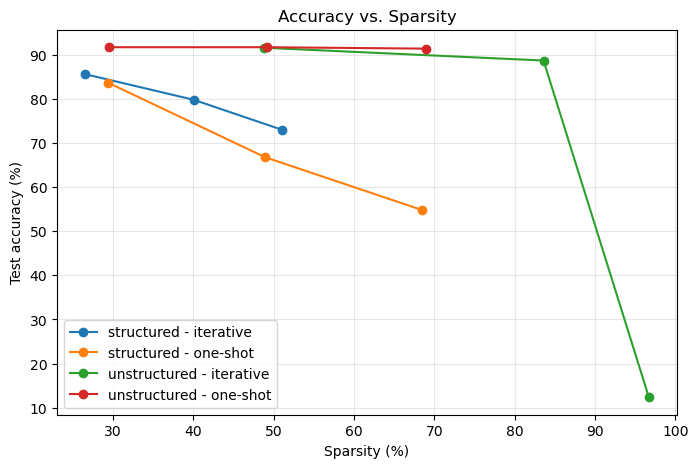

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

for (method, regime), group in df_results.groupby(["method", "regime"]):
    group_sorted = group.sort_values("sparsity_percent")
    label = f"{method} - {regime}"
    plt.plot(group_sorted["sparsity_percent"],
             group_sorted["test_acc_percent"],
             marker="o",
             label=label)

plt.xlabel("Sparsity (%)")
plt.ylabel("Test accuracy (%)")
plt.title("Accuracy vs. Sparsity")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


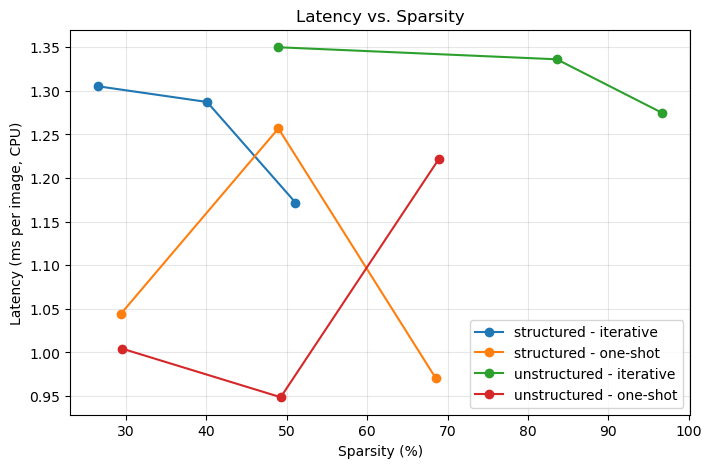

In [16]:
plt.figure(figsize=(8, 5))

for (method, regime), group in df_results.groupby(["method", "regime"]):
    group_sorted = group.sort_values("sparsity_percent")
    label = f"{method} - {regime}"
    plt.plot(group_sorted["sparsity_percent"],
             group_sorted["latency_ms_per_image"],
             marker="o",
             label=label)

plt.xlabel("Sparsity (%)")
plt.ylabel("Latency (ms per image, CPU)")
plt.title("Latency vs. Sparsity")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [17]:
# CIFAR-10 class names from the dataset object
print("Number of classes:", len(train_dataset.classes))
print("Class names:", train_dataset.classes)


Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [19]:
images, labels = next(iter(train_loader))
print(labels[:8])          # numeric class indices
print([train_dataset.classes[i] for i in labels[:8]])


tensor([4, 1, 0, 0, 5, 9, 7, 1])
['deer', 'automobile', 'airplane', 'airplane', 'dog', 'truck', 'horse', 'automobile']


In [22]:

# Recompute / ensure baseline metrics are available
baseline_params = sum(p.numel() for p in baseline_model.parameters())
baseline_file_size_mb = os.path.getsize(CHECKPOINT_PATH) / (1024 * 1024)
baseline_test_loss, baseline_test_acc = evaluate(baseline_model, test_loader, criterion)
baseline_latency_ms = avg_latency * 1000  # from measure_latency

baseline_row = {
    "model": "MobileNetV2 baseline",
    "dataset": "CIFAR-10",
    "test_acc_percent": round(baseline_test_acc * 100, 2),
    "test_loss": round(baseline_test_loss, 4),
    "total_params": baseline_params,
}

df_baseline = pd.DataFrame([baseline_row])
display(df_baseline)


,model,dataset,test_acc_percent,test_loss,total_params
0,MobileNetV2 baseline,CIFAR-10,89.8,0.3552,2236682


In [23]:
import pandas as pd

# Start from full results
df_results = pd.DataFrame(results)
df_results["test_acc_percent"] = df_results["test_acc"] * 100
df_results["sparsity_percent"] = df_results["sparsity"] * 100

# Select and order key columns
summary_cols = [
    "method",
    "regime",
    "target_sparsity",
    "sparsity_percent",
    "test_acc_percent",
    "latency_ms_per_image",
    "nonzero_params",
]

df_summary = df_results[summary_cols].copy()

# Optional: round for nicer display
df_summary["sparsity_percent"] = df_summary["sparsity_percent"].round(2)
df_summary["test_acc_percent"] = df_summary["test_acc_percent"].round(2)
df_summary["latency_ms_per_image"] = df_summary["latency_ms_per_image"].round(3)

display(df_summary)


,method,regime,target_sparsity,sparsity_percent,test_acc_percent,latency_ms_per_image,nonzero_params
0,unstructured,one-shot,0.3,29.54,91.74,1.004,1575914
1,unstructured,one-shot,0.5,49.24,91.74,0.949,1135402
2,unstructured,one-shot,0.7,68.93,91.42,1.222,694890
3,structured,one-shot,0.3,29.38,83.72,1.045,1579486
4,structured,one-shot,0.5,48.95,66.79,1.257,1141802
5,structured,one-shot,0.7,68.52,54.79,0.971,704118
6,unstructured,iterative,0.3,48.84,91.62,1.350,1144212
7,unstructured,iterative,0.5,83.59,88.72,1.336,367149
8,unstructured,iterative,0.7,96.69,12.36,1.275,74085
9,structured,iterative,0.3,26.56,85.63,1.305,1642542


In [28]:
# Filter only one-shot runs
df_oneshot = df_results[df_results["regime"] == "one-shot"].copy()

# Show full one-shot table
display(df_oneshot)

# Optional: group summary by method
oneshot_summary = (
    df_oneshot.groupby("method")[["test_acc_percent",
                                  "sparsity_percent",
                                  "latency_ms_per_image"]]
    .agg(["mean", "min", "max"])
)
display(oneshot_summary)


,test_loss,test_acc,latency_ms_per_image,total_params,nonzero_params,sparsity,method,regime,target_sparsity,test_acc_percent,sparsity_percent
0,0.366527,0.9174,1.004269,2236682,1575914,0.295423,unstructured,one-shot,0.3,91.74,29.542331
1,0.355563,0.9174,0.948668,2236682,1135402,0.492372,unstructured,one-shot,0.5,91.74,49.237218
2,0.305656,0.9142,1.222086,2236682,694890,0.689321,unstructured,one-shot,0.7,91.42,68.932106
3,0.477985,0.8372,1.044635,2236682,1579486,0.293826,structured,one-shot,0.3,83.72,29.382630
4,0.947970,0.6679,1.256873,2236682,1141802,0.489511,structured,one-shot,0.5,66.79,48.951080
5,1.264464,0.5479,0.970620,2236682,704118,0.685195,structured,one-shot,0.7,54.79,68.519530


test_acc_percent               sparsity_percent             \
                         mean    min    max             mean        min   
method                                                                    
structured          68.433333  54.79  83.72        48.951080  29.382630   
unstructured        91.633333  91.42  91.74        49.237218  29.542331   

                        latency_ms_per_image                      
                    max                 mean       min       max  
method                                                            
structured    68.519530             1.090709  0.970620  1.256873  
unstructured  68.932106             1.058341  0.948668  1.222086

In [29]:
# Filter only iterative runs
df_iter = df_results[df_results["regime"] == "iterative"].copy()

# Show full iterative table
display(df_iter)

# Optional: group summary by method
iter_summary = (
    df_iter.groupby("method")[["test_acc_percent",
                               "sparsity_percent",
                               "latency_ms_per_image"]]
    .agg(["mean", "min", "max"])
)
display(iter_summary)


,test_loss,test_acc,latency_ms_per_image,total_params,nonzero_params,sparsity,method,regime,target_sparsity,test_acc_percent,sparsity_percent
6,0.342164,0.9162,1.350001,2236682,1144212,0.488433,unstructured,iterative,0.3,91.62,48.843331
7,0.347496,0.8872,1.336157,2236682,367149,0.835851,unstructured,iterative,0.5,88.72,83.585105
8,2.294167,0.1236,1.274738,2236682,74085,0.966877,unstructured,iterative,0.7,12.36,96.687728
9,0.433467,0.8563,1.305140,2236682,1642542,0.265635,structured,iterative,0.3,85.63,26.563454
10,0.588874,0.7981,1.287202,2236682,1340333,0.400749,structured,iterative,0.5,79.81,40.074941
11,0.769825,0.7300,1.171885,2236682,1094275,0.510760,structured,iterative,0.7,73.00,51.075969


test_acc_percent               sparsity_percent             \
                         mean    min    max             mean        min   
method                                                                    
structured          79.480000  73.00  85.63        39.238121  26.563454   
unstructured        64.233333  12.36  91.62        76.372055  48.843331   

                        latency_ms_per_image                      
                    max                 mean       min       max  
method                                                            
structured    51.075969             1.254742  1.171885  1.305140  
unstructured  96.687728             1.320299  1.274738  1.350001

In [30]:
# Select key columns for comparison
cols = ["method", "target_sparsity", "sparsity_percent",
        "test_acc_percent", "latency_ms_per_image"]

print("=== One-shot ===")
display(df_oneshot[cols].sort_values(["method", "target_sparsity"]))

print("=== Iterative ===")
display(df_iter[cols].sort_values(["method", "target_sparsity"]))


=== One-shot ===


,method,target_sparsity,sparsity_percent,test_acc_percent,latency_ms_per_image
3,structured,0.3,29.382630,83.72,1.044635
4,structured,0.5,48.951080,66.79,1.256873
5,structured,0.7,68.519530,54.79,0.970620
0,unstructured,0.3,29.542331,91.74,1.004269
1,unstructured,0.5,49.237218,91.74,0.948668
2,unstructured,0.7,68.932106,91.42,1.222086


=== Iterative ===


,method,target_sparsity,sparsity_percent,test_acc_percent,latency_ms_per_image
9,structured,0.3,26.563454,85.63,1.305140
10,structured,0.5,40.074941,79.81,1.287202
11,structured,0.7,51.075969,73.00,1.171885
6,unstructured,0.3,48.843331,91.62,1.350001
7,unstructured,0.5,83.585105,88.72,1.336157
8,unstructured,0.7,96.687728,12.36,1.274738


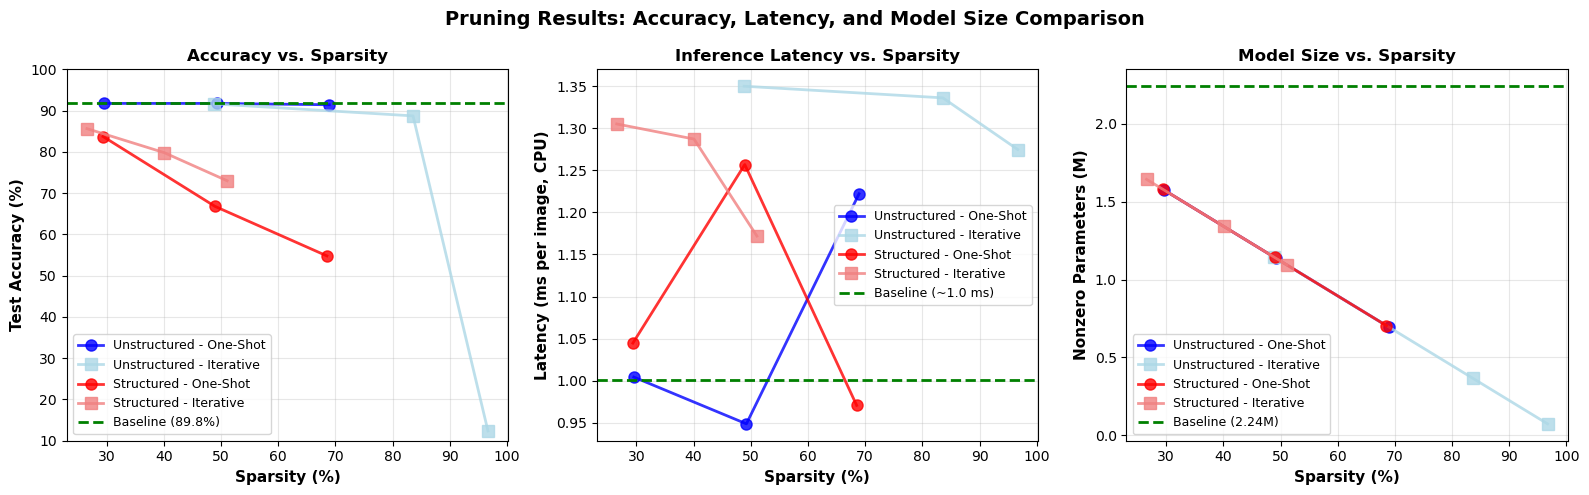

✓ Three-metric comparison plot saved as 'pruning_comparison_all_metrics.png'


In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Create a large figure with 3 subplots (one for each metric)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("Pruning Results: Accuracy, Latency, and Model Size Comparison", 
             fontsize=14, fontweight="bold")

# Define colors and markers for clarity
colors_unstr = {"one-shot": "blue", "iterative": "lightblue"}
colors_struct = {"one-shot": "red", "iterative": "lightcoral"}
markers = {"one-shot": "o", "iterative": "s"}

# ==================== SUBPLOT 1: Accuracy vs Sparsity ====================
ax = axes[0]
for method in ["unstructured", "structured"]:
    for regime in ["one-shot", "iterative"]:
        df_subset = df_results[(df_results["method"] == method) & 
                               (df_results["regime"] == regime)]
        df_subset = df_subset.sort_values("sparsity_percent")
        
        color = colors_unstr[regime] if method == "unstructured" else colors_struct[regime]
        marker = markers[regime]
        label = f"{method.capitalize()} - {regime.title()}"
        
        ax.plot(df_subset["sparsity_percent"],
                df_subset["test_acc_percent"],
                marker=marker,
                markersize=8,
                linewidth=2,
                color=color,
                label=label,
                alpha=0.8)

# Add baseline line
baseline_acc = df_results[df_results["method"] == "unstructured"]["test_acc_percent"].iloc[0]
ax.axhline(y=baseline_acc, color="green", linestyle="--", linewidth=2, label="Baseline (89.8%)")

ax.set_xlabel("Sparsity (%)", fontsize=11, fontweight="bold")
ax.set_ylabel("Test Accuracy (%)", fontsize=11, fontweight="bold")
ax.set_title("Accuracy vs. Sparsity", fontsize=12, fontweight="bold")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9, loc="best")
ax.set_ylim([10, 100])

# ==================== SUBPLOT 2: Latency vs Sparsity ====================
ax = axes[1]
for method in ["unstructured", "structured"]:
    for regime in ["one-shot", "iterative"]:
        df_subset = df_results[(df_results["method"] == method) & 
                               (df_results["regime"] == regime)]
        df_subset = df_subset.sort_values("sparsity_percent")
        
        color = colors_unstr[regime] if method == "unstructured" else colors_struct[regime]
        marker = markers[regime]
        label = f"{method.capitalize()} - {regime.title()}"
        
        ax.plot(df_subset["sparsity_percent"],
                df_subset["latency_ms_per_image"],
                marker=marker,
                markersize=8,
                linewidth=2,
                color=color,
                label=label,
                alpha=0.8)

# Add baseline line
baseline_latency = 1.001  # from your baseline metrics
ax.axhline(y=baseline_latency, color="green", linestyle="--", linewidth=2, label="Baseline (~1.0 ms)")

ax.set_xlabel("Sparsity (%)", fontsize=11, fontweight="bold")
ax.set_ylabel("Latency (ms per image, CPU)", fontsize=11, fontweight="bold")
ax.set_title("Inference Latency vs. Sparsity", fontsize=12, fontweight="bold")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9, loc="best")

# ==================== SUBPLOT 3: Model Size vs Sparsity ====================
ax = axes[2]
for method in ["unstructured", "structured"]:
    for regime in ["one-shot", "iterative"]:
        df_subset = df_results[(df_results["method"] == method) & 
                               (df_results["regime"] == regime)]
        df_subset = df_subset.sort_values("sparsity_percent")
        
        color = colors_unstr[regime] if method == "unstructured" else colors_struct[regime]
        marker = markers[regime]
        label = f"{method.capitalize()} - {regime.title()}"
        
        ax.plot(df_subset["sparsity_percent"],
                df_subset["nonzero_params"] / 1e6,  # convert to millions
                marker=marker,
                markersize=8,
                linewidth=2,
                color=color,
                label=label,
                alpha=0.8)

# Add baseline line
baseline_params = 2.24
ax.axhline(y=baseline_params, color="green", linestyle="--", linewidth=2, label="Baseline (2.24M)")

ax.set_xlabel("Sparsity (%)", fontsize=11, fontweight="bold")
ax.set_ylabel("Nonzero Parameters (M)", fontsize=11, fontweight="bold")
ax.set_title("Model Size vs. Sparsity", fontsize=12, fontweight="bold")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9, loc="best")

plt.tight_layout()
plt.savefig("pruning_comparison_all_metrics.png", dpi=300, bbox_inches="tight")
plt.show()

print("✓ Three-metric comparison plot saved as 'pruning_comparison_all_metrics.png'")
